In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [122]:
train_raw = pd.read_csv('./input data/train.csv')
test_raw = pd.read_csv('./input data/test.csv')

train_ids = train_raw['id']
train_y = train_raw['failure']
train_x = train_raw.drop(['id', 'failure'], axis='columns')

test_ids = test_raw['id']
test_x = test_raw.drop(['id'], axis='columns')

In [123]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['attribute_2', 'attribute_3']
encode_features = ['attribute_0', 'attribute_1']
encoder_output = ['a0_mat7', 'a1_mat6', 'a1_mat8']
ohe = OneHotEncoder( categories=[ ['material_5', 'material_7'], ['material_5', 'material_6', 'material_8']],
                   drop='first', sparse=False, handle_unknown='ignore')
ohe.fit(train_x[encode_features])

train_x[encoder_output] = ohe.transform(train_x[encode_features])
train_x = train_x.drop(columns=encode_features)
#train_x = train_x.drop(columns=['product_code'])

test_x[encoder_output] = ohe.transform(test_x[encode_features])
test_x = test_x.drop(columns=encode_features)
#test_x = test_x.drop(columns=['product_code'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [124]:
train_pc = train_x['product_code']
test_pc = test_x['product_code']
train_x = train_x.drop(columns=['product_code'])
test_x = test_x.drop(columns=['product_code'])

In [125]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer()
train_x = imp.fit_transform(train_x)
test_x = imp.transform(test_x)

train_x = pd.DataFrame(train_x, columns=imp.feature_names_in_)
train_x['product_code'] = train_pc

test_x = pd.DataFrame(test_x, columns=imp.feature_names_in_)
test_x['product_code'] = test_pc

In [126]:
print(train_x.head())

   loading  attribute_2  attribute_3  measurement_0  measurement_1  \
0    80.10          9.0          5.0            7.0            8.0   
1    84.89          9.0          5.0           14.0            3.0   
2    82.43          9.0          5.0           12.0            1.0   
3   101.07          9.0          5.0           13.0            2.0   
4   188.06          9.0          5.0            9.0            2.0   

   measurement_2  measurement_3  measurement_4  measurement_5  measurement_6  \
0            4.0         18.040         12.518         15.748         19.292   
1            3.0         18.213         11.540         17.717         17.893   
2            5.0         18.057         11.652         16.738         18.240   
3            6.0         17.295         11.188         18.576         18.339   
4            8.0         19.346         12.950         16.990         15.746   

   ...  measurement_12  measurement_13  measurement_14  measurement_15  \
0  ...          15.193  

In [128]:
from sklearn.ensemble import IsolationForest

feature_names = imp.feature_names_in_

outlier_detector = IsolationForest()
results = outlier_detector.fit_predict(train_x[feature_names])

-2068


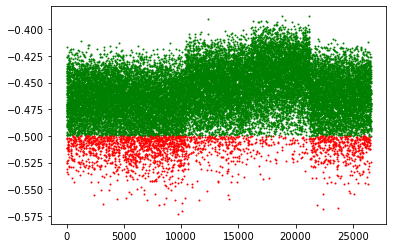

In [130]:
scores = outlier_detector.score_samples(train_x[feature_names])
plt.scatter(train_ids[results>0], scores[results>0], c='green', s=1)
plt.scatter(train_ids[results<0], scores[results<0], c='red', s=1)
print(np.sum(results[results<0], axis=0))

In [248]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

In [135]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits=5)
groups = train_x['product_code']

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

param_grid = dict()
param_grid['n_estimators'] = [100]
param_grid['max_depth'] = np.arange(1, 5)
param_grid['ccp_alpha'] = np.arange(0, 0.05, 0.01)
param_grid['n_jobs'] = [-1]
params = ParameterGrid(param_grid)

total_results = []
for g in params:
    f1_scores = []
    accuracies = []
    roc_auc_scores = []

    for train_index, test_index in kf.split(train_x, train_y, groups):
        pipe = Pipeline([('rf', RandomForestClassifier())])
        pipe['rf'].set_params(**g)
        x_tr = train_x.iloc[train_index][feature_names]
        x_va = train_x.iloc[test_index][feature_names]
        y_tr = train_y[train_index]
        y_va = train_y[test_index]
        pipe.fit(x_tr, y_tr)
        preds = pipe.predict(x_va)
        f1_scores.append(f1_score(y_va, preds))
        roc_auc_scores.append(roc_auc_score(y_va, preds))
        accuracies.append(pipe.score(x_va, y_va))
    
    total_results.append( (g, np.mean(f1_scores), np.mean(accuracies), np.mean(roc_auc_scores)))

In [170]:
result_df = pd.DataFrame(total_results, columns=['params', 'f1', 'accuracy', 'roc_auc'])
result_df = result_df.sort_values('roc_auc', axis=0, ascending=False)
print(result_df.head())

                                               params   f1  accuracy  roc_auc
0   {'ccp_alpha': 0.0, 'max_depth': 1, 'n_estimato...  0.0  0.787243      0.5
1   {'ccp_alpha': 0.0, 'max_depth': 2, 'n_estimato...  0.0  0.787243      0.5
18  {'ccp_alpha': 0.04, 'max_depth': 3, 'n_estimat...  0.0  0.787243      0.5
17  {'ccp_alpha': 0.04, 'max_depth': 2, 'n_estimat...  0.0  0.787243      0.5
16  {'ccp_alpha': 0.04, 'max_depth': 1, 'n_estimat...  0.0  0.787243      0.5


In [256]:
from sklearn.linear_model import LogisticRegression

logreg_param_grid = dict()
logreg_param_grid['penalty'] = ['elasticnet']
logreg_param_grid['C'] = [ 0.01]
logreg_param_grid['max_iter'] = [1000]
logreg_param_grid['solver'] = ['saga']
logreg_param_grid['l1_ratio'] = np.arange(0.1, 0.9, 0.1)
logreg_param_grid['n_jobs'] = [-1]
logreg_params = ParameterGrid(logreg_param_grid)

logreg_total_results = []
unscaled_total_results = []
quantile_total_results = []

for g in logreg_params:
    unscaled_f1_scores = []
    unscaled_accuracies = []
    unscaled_roc_auc_scores = []
    
    quantile_f1_scores = []
    quantile_accuracies = []
    quantile_roc_auc_scores = []
    
    f1_scores = []
    accuracies = []
    roc_auc_scores = []
    for train_index, test_index in kf.split(train_x, train_y, groups):
        x_tr = train_x.iloc[train_index][feature_names]
        x_va = train_x.iloc[test_index][feature_names]
        y_tr = train_y[train_index]
        y_va = train_y[test_index]
        
        pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
        pipe['lr'].set_params(**g)
        pipe.fit(x_tr, y_tr)
        probs = pipe.predict_proba(x_va)[:,1]
        preds = pipe.predict(x_va)
        f1_scores.append(f1_score(y_va, preds))
        accuracies.append(pipe.score(x_va, y_va))
        roc_auc_scores.append(roc_auc_score(y_va, probs))
        
        
        quantile_pipe = Pipeline([('scaler', PowerTransformer()), ('lr', LogisticRegression())])
        quantile_pipe['lr'].set_params(**g)
        quantile_pipe.fit(x_tr, y_tr)
        quantile_probs = quantile_pipe.predict_proba(x_va)[:,1]
        quantile_preds = quantile_pipe.predict(x_va)
        quantile_f1_scores.append(f1_score(y_va, quantile_preds))
        quantile_accuracies.append(quantile_pipe.score(x_va, y_va))
        quantile_roc_auc_scores.append(roc_auc_score(y_va, quantile_probs))
    

    logreg_total_results.append( (g, np.mean(f1_scores), np.mean(accuracies), np.mean(roc_auc_scores)))
    quantile_total_results.append( (g, np.mean(quantile_f1_scores), np.mean(quantile_accuracies), np.mean(quantile_roc_auc_scores)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning:

In [257]:
logreg_result_df = pd.DataFrame(logreg_total_results, columns=['params', 'f1', 'accuracy', 'roc_auc'])
logreg_result_df = logreg_result_df.sort_values('roc_auc', axis=0, ascending=False)
print(logreg_result_df.head()[['roc_auc', 'f1', 'accuracy']])


quantile_result_df = pd.DataFrame(quantile_total_results, columns=['params', 'f1', 'accuracy', 'roc_auc'])
quantile_result_df = quantile_result_df.sort_values('roc_auc', axis=0, ascending=False)
print(quantile_result_df.head()[['roc_auc', 'f1', 'accuracy']])

    roc_auc        f1  accuracy
7  0.589653  0.003191  0.787067
6  0.589621  0.003516  0.787024
5  0.589552  0.003840  0.787058
4  0.589395  0.003840  0.787058
3  0.589190  0.003837  0.786951
    roc_auc        f1  accuracy
7  0.589193  0.000000  0.787243
6  0.589134  0.000000  0.787243
5  0.589077  0.000000  0.787243
4  0.588945  0.000000  0.787243
3  0.588813  0.000328  0.787278


In [258]:
print(logreg_result_df.head()['params'])
print(quantile_result_df.head()['params'])

7    {'C': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000,...
6    {'C': 0.01, 'l1_ratio': 0.7000000000000001, 'm...
5    {'C': 0.01, 'l1_ratio': 0.6, 'max_iter': 1000,...
4    {'C': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000,...
3    {'C': 0.01, 'l1_ratio': 0.4, 'max_iter': 1000,...
Name: params, dtype: object
7    {'C': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000,...
6    {'C': 0.01, 'l1_ratio': 0.7000000000000001, 'm...
5    {'C': 0.01, 'l1_ratio': 0.6, 'max_iter': 1000,...
4    {'C': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000,...
3    {'C': 0.01, 'l1_ratio': 0.4, 'max_iter': 1000,...
Name: params, dtype: object


In [268]:
p = quantile_result_df.iloc[0]['params']
final_pipe = Pipeline([('scaler', PowerTransformer()), ('lr', LogisticRegression())])
final_pipe['lr'].set_params(**p)
final_pipe.fit(train_x[feature_names], train_y)
predictions = final_pipe.predict_proba(test_x[feature_names])[:,1]
feature_importances = final_pipe['lr'].coef_.reshape(-1,)

p_2 = logreg_result_df.iloc[0]['params']
final_pipe_2 = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
final_pipe_2['lr'].set_params(**p_2)
final_pipe_2.fit(train_x[feature_names], train_y)
predictions_2 = final_pipe_2.predict_proba(test_x[feature_names])[:,1]

feature_importances = final_pipe['lr'].coef_.reshape(-1,)

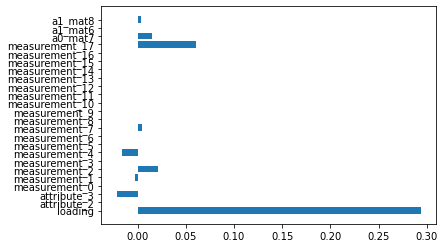

In [269]:
y_pos = np.arange(len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_pos, feature_importances, align='center')
ax.set_yticks(y_pos, labels=feature_names)
plt.show()

In [270]:
pred_df = pd.DataFrame()
pred_df['prob'] = predictions
pred_df['rank'] = pred_df.rank()
print(pred_df.head())

       prob     rank
0  0.204315   9786.0
1  0.176070   5247.0
2  0.193290   7965.0
3  0.193338   7979.0
4  0.320336  20223.0


In [271]:
submission = pd.DataFrame()
submission['id'] = test_ids
submission['failure'] = pred_df['rank']
submission.to_csv('submission.csv', header=True, index=False)

In [214]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

svc_param_grid = dict()
svc_param_grid['kernel'] = ['sigmoid']
svc_param_grid['C'] = [0.0001, 0.001, 0.01, 0.1, 1]
svc_param_grid['max_iter'] = [10000]
svc_param_grid['probability'] = [False]
svc_params = ParameterGrid(svc_param_grid)

svc_total_results = []
unscaled_svc_total_results = []

for g in svc_params:
    unscaled_svc_f1_scores = []
    unscaled_svc_accuracies = []
    unscaled_svc_roc_auc_scores = []
    
    svc_f1_scores = []
    svc_accuracies = []
    svc_roc_auc_scores = []
    for train_index, test_index in kf.split(train_x, train_y, groups):
        x_tr = train_x.iloc[train_index][feature_names]
        x_va = train_x.iloc[test_index][feature_names]
        y_tr = train_y[train_index]
        y_va = train_y[test_index]
        
        pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        pipe['svc'].set_params(**g)
        pipe.fit(x_tr, y_tr)
        probs = pipe.decision_function(x_va)
        preds = pipe.predict(x_va)
        svc_f1_scores.append(f1_score(y_va, preds))
        svc_accuracies.append(pipe.score(x_va, y_va))
        svc_roc_auc_scores.append(roc_auc_score(y_va, probs))
        
    svc_total_results.append( (g, np.mean(svc_f1_scores), np.mean(svc_accuracies), np.mean(svc_roc_auc_scores)))
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_it

In [216]:
svc_result_df = pd.DataFrame(svc_total_results, columns=['params', 'f1', 'accuracy', 'roc_auc'])
svc_result_df = svc_result_df.sort_values('roc_auc', axis=0, ascending=False)
print(svc_result_df.head()[['roc_auc', 'f1', 'accuracy']])


    roc_auc        f1  accuracy
0  0.540104  0.000000  0.787243
1  0.535624  0.000000  0.787243
3  0.534340  0.007915  0.785655
2  0.533647  0.000000  0.787243
4  0.528367  0.131434  0.747479


In [211]:
print(svc_result_df.head())

                                              params        f1  accuracy  \
1  {'C': 0.0001, 'kernel': 'sigmoid', 'max_iter':...  0.352420  0.244505   
5  {'C': 0.01, 'kernel': 'sigmoid', 'max_iter': 1...  0.347944  0.298477   
3  {'C': 0.001, 'kernel': 'sigmoid', 'max_iter': ...  0.348724  0.285389   
7  {'C': 0.1, 'kernel': 'sigmoid', 'max_iter': 10...  0.349215  0.250141   
9  {'C': 1, 'kernel': 'sigmoid', 'max_iter': 1000...  0.313419  0.500641   

    roc_auc  
1  0.554203  
5  0.546352  
3  0.543186  
7  0.528320  
9  0.518944  
